In [1]:
%pylab inline

import math
import datetime
import pandas as pd
from pprint import pprint

Populating the interactive namespace from numpy and matplotlib


In [2]:
from ipyleaflet import Map, basemaps, DrawControl, TileLayer, LayersControl
from IPython.display import display

In [3]:
# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self,eeImageObject, visParams, name):
    mapID = ee.Image(eeImageObject).getMapId(visParams)
    tiles = TileLayer(
        url = mapID['tile_fetcher'].url_format,
        attribution="Map Data © <a href=’https://earthengine.google.com’>Google Earth Engine</a>",
        name = name,
    )
    self.add_layer(tiles)
    
Map.add_ee_layer = add_ee_layer

In [4]:
m = Map(center=(0,35),zoom=8,basemap=basemaps.CartoDB.Positron)
m.scroll_wheel_zoom = True

draw_control = DrawControl()
draw_control.polygon = {
    "shapeOptions": {
        "fillColor": "#6be5c3",
        "color": "#6be5c3",
        "fillOpacity": 1.0
    },
    "drawError": {
        "color": "#dd253b",
        "message": "I'm sorry Dave, I'm afraid I can't do that"
    },
    "allowIntersection": False
}
draw_control.circle = {
    "shapeOptions": {
        "fillColor": "#efed69",
        "color": "#efed69",
        "fillOpacity": 1.0
    }
}
draw_control.rectangle = {
    "shapeOptions": {
        "fillColor": "#fca45d",
        "color": "#fca45d",
        "fillOpacity": 1.0
    }
}

m.add_control(draw_control)

m.add_control(LayersControl(position='topright'))

In [5]:
display(m)

Map(center=[0, 35], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

In [6]:
import ee
ee.Initialize()
import rendvi
from rendvi import eeCollections

In [7]:
# time information to handle image collection
iniYear = 2005
endYear = 2015

# convert start and end dates to EE date objects
eeIni = ee.Date.fromYMD(iniYear,1,1,)
eeEnd = ee.Date.fromYMD(endYear,12,31)


In [8]:
mod = eeCollections.MOD09GQ['imageCollection'].filterDate(eeIni,eeEnd)
mod1km = eeCollections.MOD09GA['imageCollection'].filterDate(eeIni,eeEnd)

In [9]:
masked = rendvi.Masking.applyModis(mod,mod1km)
withNdvi = rendvi.Utils.addNDBand(masked,
                                  b1=eeCollections.MOD09GQ['nir'],
                                  b2=eeCollections.MOD09GQ['red'],
                                  outName='ndvi')

In [10]:
full = rendvi.Rendvi(withNdvi,'ndvi')
dekads = full.getDekadImages(includeQa=False)
despiked = dekads.applyDespike(window=30,step=10,keepBandPattern=None)

In [11]:
img = ee.Image(despiked.imageCollection.sort("system:time_start").first())

m.add_ee_layer(img,{'bands':"ndvi",'min':-0.2,'max':1,'palette':'gray,beige,green,darkgreen'},'NDVI')

In [12]:
geo = ee.Geometry.Point([36.8412,-1.3584]) # Nairobi

df = despiked.getTimeSeries(geo,250)


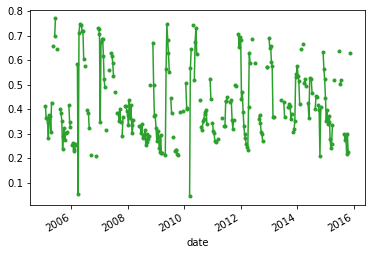

In [13]:
df.ndvi.plot(marker='o',color='C2',markersize=3)

In [14]:
from rendvi import forecast

In [15]:
fm = forecast.Harmonics(nCycles=3)

In [16]:
fm.fit(despiked)

In [17]:
harmonicTrend = fm.predict(despiked)

In [18]:
fitted = harmonicTrend.getTimeSeries(geo,250)

In [19]:
residual = fitted.predicted - df.ndvi

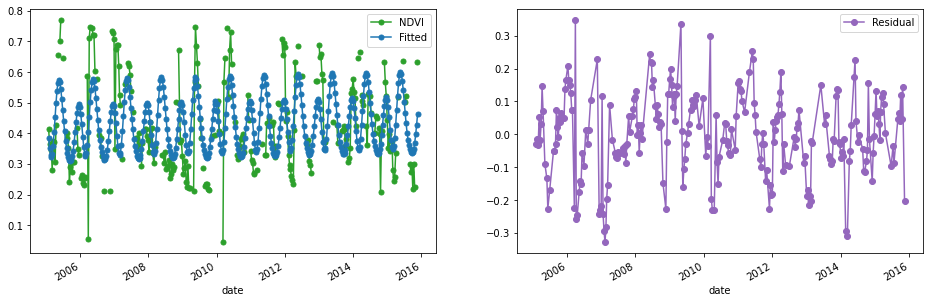

In [20]:
fig,ax = plt.subplots(ncols=2,figsize=(16,5))

df.ndvi.plot(ax=ax[0],marker='o',color='C2',markersize=5,label='NDVI')
fitted.predicted.plot(ax=ax[0],color='C0',marker='o',markersize=5,label='Fitted')
ax[0].legend()

residual.dropna().plot(ax=ax[1],color='C4',marker='o',label='Residual')
ax[1].legend()

plt.show()

In [21]:
harmonicCoefs = fm.coefficients

# Compute phase and amplitude.
# Scale to [0, 1] from radians
phase = harmonicCoefs.select('sin_1')\
    .atan2(harmonicCoefs.select('cos_1'))\
    .unitScale(-math.pi, math.pi)
    
amplitude = harmonicCoefs.select('sin_1')\
    .hypot(harmonicCoefs.select('cos_1'))\
    .multiply(5) # Add a scale factor for visualization.

# Compute the mean NDVI.
meanNdvi= full.imageCollection.select('ndvi').mean();

# Use the HSV to RGB transform to display phase and amplitude.
rgb = ee.Image.cat([
  phase,      # hue
  amplitude,  # saturation (difference from white)
  meanNdvi    # value (difference from black)
]).hsvToRgb();


In [22]:
m.add_ee_layer(rgb,{},'Harmonics')

In [23]:
futureColl = fm.getDummyCollection('2016-01-01','2021-01-01')

In [24]:
futureDekads = futureColl.getDekadImages(includeQa=False)

In [25]:
prediction = fm.predict(futureDekads)

In [26]:
pred = prediction.getTimeSeries(geo,250)

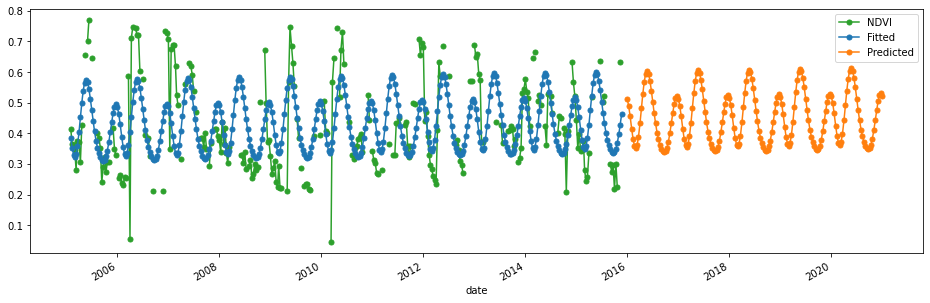

In [27]:
fig,ax = plt.subplots(figsize=(16,5))

df.ndvi.plot(ax=ax,marker='o',color='C2',markersize=5,label='NDVI')
fitted.predicted.plot(ax=ax,color='C0',marker='o',markersize=5,label='Fitted')
pred.predicted.plot(ax=ax,color='C1',marker='o',markersize=5,label='Predicted')
ax.legend()

plt.show()